/home/lihanghang/anaconda3/envs/TensorFlow/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


**************************************************************************

**************************当前是第1列数据,共4列**************************

**************************************************************************

[[100.        ]
 [100.16308454]
 [ 99.21241628]
 [100.29503553]
 [100.28310791]
 [102.34537451]
 [102.37744405]
 [102.30846869]
 [102.84008452]
 [103.06689346]
 [102.9200598 ]
 [105.55958478]
 [105.39164371]
 [104.84953896]
 [104.10360583]
 [102.98370181]
 [102.43279966]
 [101.14050334]
 [101.76972026]
 [101.77500322]
 [101.94263415]
 [101.93869395]
 [102.66272147]
 [ 96.00475801]
 [ 93.8755659 ]
 [ 94.23731654]
 [ 94.49578855]
 [ 94.01645704]
 [ 93.52469797]
 [ 93.37077434]
 [ 93.00514487]
 [ 92.66426758]
 [ 91.9534583 ]
 [ 91.81588536]]


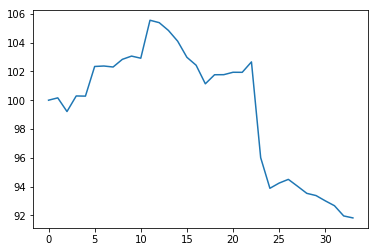

Tensor("rnn/Reshape_1:0", shape=(?, 5, 10), dtype=float32)


KeyboardInterrupt: 

In [1]:
# Imports
import numpy as np
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import matplotlib.dates as mdate
%matplotlib inline 

# 加载数据
path = "./dataSets/信息技术服务业景气指数&市场风险预警数据.xlsx"
# skipfooter=3

Matrix_pre = np.zeros(shape=(7,1))

#print (Matrix_pre)

for i in range(1,2):
    
    print('**************************************************************************\n')
    print('**************************当前是第'+str(i)+'列数据,共4列**************************\n')
    print('**************************************************************************\n')

    dataset = pd.read_excel(path, sheet_name = 'hengcheng', usecols= [i],  nrows = 34)
    dataset = np.array(dataset)

    print(dataset)

    plt.plot(dataset)
    plt.show()

    # normalize the dataset
    scaler = MinMaxScaler(feature_range=(0, 1))
    dataSet = scaler.fit_transform(dataset)




    # split into train and test sets; 80% 是训练数据，其余是测试数据
    train_size = int(len(dataSet) * 0.8)
    test_size = len(dataSet) - train_size
    train, test = dataSet[0:train_size], dataSet[train_size:len(dataSet)]

    # 数据格式转化(t,t+1)
    def convert_data(data, time_step=1):
        data_X,data_Y = [],[]  
        for i in range(len(data) - time_step - 1):
            x = data[i: (i + time_step)]  
            y = data[i+1:i + time_step+1]      
            data_X.append(x.tolist())
            data_Y.append(y.tolist()) 
        return data_X, data_Y

    # fix random seed for reproducibility
    np.random.seed(7)

    # use this function to prepare the train and test datasets for modeling
    #time_step=5
    time_step = 5      #时间步
    train_x, train_y = convert_data(train, time_step)
    test_x, test_y = convert_data(test, time_step)

    #———————————————————形成训练集—————————————————————
    #设置常量
    hidden_unit = 10       #hidden layer units 记忆和储存过去状态的节点个数
    batch_size = 4    #每一批次训练多少个样例
    input_size = 1      #输入层维度
    output_size = 1     #输出层维度
    lr = 0.0001       #学习率

    import tensorflow as tf

    # LSTM 的 X 需要有这样的结构： [samples, time steps, features]，所以做一下变换
    X = tf.placeholder(tf.float32, [None,time_step,input_size] ,name = 'inputs')    #每批次输入网络的tensor
    Y = tf.placeholder(tf.float32, [None,time_step,output_size] ,name = 'outputs')   #每批次tensor对应的标签
    # 输入层、输出层权重、偏置
    with tf.name_scope('layer'):
            with tf.name_scope('weights'):
                weights={
                         'in':tf.Variable(tf.random_normal([input_size,hidden_unit])),
                         'out':tf.Variable(tf.random_normal([hidden_unit,1]))
                         }
            with tf.name_scope('biases'):
                biases={
                        'in':tf.Variable(tf.constant(0.1,shape=[hidden_unit,])),
                        'out':tf.Variable(tf.constant(0.1,shape=[1,]))
                        }

    def lstm(batch):  #参数：输入网络批次数目

        w_in = weights['in']
        b_in = biases['in']
        input = tf.reshape(X,[-1,input_size])  #需要将tensor转成2维进行计算，计算后的结果作为隐藏层的输入

        lstm_cell = tf.nn.rnn_cell.BasicLSTMCell(hidden_unit) #10个节点
        input_lstm = tf.matmul(input, w_in) + b_in
        input_lstm = tf.reshape(input_lstm, [-1, time_step, hidden_unit])  #将tensor转成3维，作为lstm cell的输入      
        print(input_lstm)
        init_state = lstm_cell.zero_state(batch,dtype = tf.float32)
        # output_rnn是记录lstm每个隐状态输出节点的结果，final_states是最后一个cell的结果，数据格式为tuple
        output_rnn, final_states = tf.nn.dynamic_rnn(
            lstm_cell, 
            input_lstm, 
            initial_state = init_state, 
            dtype = tf.float32) 

        output = tf.reshape(output_rnn, [-1, hidden_unit]) #  作为输出层的输入
        w_out = weights['out']
        b_out = biases['out']
        # 预测数据
        multi = tf.matmul(output, w_out)
        pred = tf.add(multi, b_out, name='preds')  
        return pred, final_states

    train_loss = []
    def train_lstm():   
        global batch_size
        iteration = 1
        epochs = 1000
    #     with tf.variable_scope("sec_lstm"):
        pred, _ = lstm(batch_size)
        # 损失函数
        loss = tf.reduce_mean(tf.square(tf.reshape(pred,[-1])-tf.reshape(Y, [-1])))
        #tf.summary.scalar('loss_function', loss)
        train_op = tf.train.AdamOptimizer(lr).minimize(loss)
        saver = tf.train.Saver(tf.global_variables())
        with tf.Session() as sess:
            keep_prob = tf.placeholder(tf.float32)
            sess.run(tf.global_variables_initializer())
            # summaries合并
            #merged = tf.summary.merge_all()    
            # 写到指定的磁盘路径中
            #train_writer = tf.summary.FileWriter(log_dir + '/train', sess.graph)
            # 重复训练5000次
            for e in range(epochs):
                step=0
                start = 0
                end = start + batch_size
                while(end < len(train_x)):
                    x = train_x[start:end]
                    y = train_y[start:end]
                    _,loss_ = sess.run([train_op, loss], feed_dict = {X: x, Y:y, keep_prob : 0.3})
                    start += batch_size
                    end = start + batch_size
                    # 每10步保存一次参数
                    if step% 10 == 0:                    
                        print("Epoch: {}/{}".format(e, epochs),
                        "Iteration: {:d}".format(iteration),
                        "Train loss: {:6f}".format(loss_))
                        #train_writer.add_summary(summary, e);

                    train_loss.append(loss_)
                    iteration += 1  
                    step += 1
            saver.save(sess, "./models/Info-hecheng-lstm/predict.ckpt")
#              # 保存二进制模型
#             builder = tf.saved_model.builder.SavedModelBuilder("./models/Info-hecheng-model/model_"+ str(i))
#             builder.add_meta_graph_and_variables(sess, ['mytag'])
#             builder.save()
            #绘训练过程指标图
            t = np.arange(iteration - 1)
            plt.figure(figsize = (9,6))
            plt.plot(t, np.array(train_loss),  'r-')
            plt.xlabel("iteration")
            plt.ylabel("Loss")
            plt.legend(['train'], loc='upper right')
            plt.show()        

    with tf.variable_scope('rnn', reuse=tf.AUTO_REUSE):
        train_lstm()

    from sklearn.metrics import mean_squared_error
    import math

    def prediction():

            pred, _ = lstm(1)  # 预测时只输入[1,time_step,inputSize]的测试数据
            saver = tf.train.Saver(tf.global_variables())
            #预测季度
            pre_quarter = 7
            with tf.Session() as sess:
                # 参数恢复
                module_file = tf.train.latest_checkpoint("./models/Info-hecheng-lstm/")
                saver.restore(sess, module_file)
                # 取训练集最后一行为测试样本. shape=[1,time_step,inputSize]
                prev_seq = train_x[-1]
                print(prev_seq)
                predict = []
                # 得到之后10个季度的预测结果
                for i in range(pre_quarter):
                    next_seq = sess.run(pred,feed_dict={X:[prev_seq]})
                    predict.append(next_seq[-1])   
                    #每次得到最后一个时间步的预测结果，与之前的数据加在一起，形成新的测试样本
                    #np.vstack()表示垂直（按照行顺序）的把数组给堆叠起来。
                    prev_seq = np.vstack((prev_seq[1:],next_seq[-1]))

                #得到实际预测值
                predictY = scaler.inverse_transform(predict)

                testY = scaler.inverse_transform(test)
                print("预测值：", predictY)
                print("真实值：",testY )

                global Matrix_pre
                Matrix_pre = (np.hstack((Matrix_pre,predictY)))


                #以折线图表示结果
                plt.figure()
                plt.title("lead index")
                plt.plot(list(range(len(testY))), testY, 'cx--', list(range(len(predict))), predictY, 'b--')
                plt.xlabel("date-num")
                plt.ylabel("index")
                plt.legend(['train', 'pred'], loc='upper right')
                plt.plot()
                plt.show()

    with tf.variable_scope('rnn', reuse = tf.AUTO_REUSE):
        prediction() 

#存进excel文件
Matrix_input = pd.DataFrame(Matrix_pre)
writer = pd.ExcelWriter('./信息技术服务业景气合成分析预测数据.xlsx')
Matrix_input.to_excel(writer, float_format='%.2f', header = False, index = False,) # float_format 控制精度
writer.save()

print('**************************************************************************\n')
print('*********************************迭代结束*********************************\n')
print('**************************************************************************')